In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

drive.mount('/content/gdrive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data_dir = '/content/gdrive/My Drive/data_source/food_segmentation/unet/training_data/train/'
label_dir = '/content/gdrive/My Drive/data_source/food_segmentation/unet/training_label/train/'
sample_path = '/content/gdrive/My Drive/data_source/food_segmentation/unet/sample_images.npy'

In [0]:
maskgen_args = dict(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
)

imagegen_args = dict(
    featurewise_center=True,
    featurewise_std_normalization=True,
    **maskgen_args
)

image_datagen = ImageDataGenerator(**imagegen_args)
mask_datagen = ImageDataGenerator(**maskgen_args)

image_datagen.fit(np.load(sample_path))

data_generator = zip(
    image_datagen.flow_from_directory(
        data_dir,
        target_size=(512, 512),
        color_mode='rgb',
        batch_size=4,
        class_mode=None,
        save_format='jpeg',
        seed=1
    ),
    mask_datagen.flow_from_directory(
        label_dir,
        target_size=(512, 512),
        color_mode='grayscale',
        batch_size=4,
        class_mode=None,
        save_format='png',
        seed=1
    )
)

Found 12090 images belonging to 1 classes.
Found 12090 images belonging to 1 classes.


In [0]:
print(image_datagen.mean, image_datagen.std)
print(mask_datagen.mean, mask_datagen.std)

[[[32.768 32.768 32.768]]] [[[72.57518  66.39548  61.829777]]]
None None


In [0]:
def unet(input_size=(512,512,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    print(conv1.shape)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

In [0]:
unet_model = unet()
unet_model.compile(
    optimizer=Adam(lr=1e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

unet_model.summary()




(?, 512, 512, 64)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
_______________________________________________________

In [0]:
unet_model.fit_generator(
    data_generator, 
    epochs=2,
    steps_per_epoch=4096,
    callbacks=[keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/data_source/food_segmentation/unet/model_checkpoint_{epoch:02d}.hdf5")]
)

Epoch 1/2
4096/4096 [==============================] - 12875s 3s/step - loss: 0.4928 - acc: 0.7773
Epoch 2/2
4096/4096 [==============================] - 11843s 3s/step - loss: 0.3765 - acc: 0.8323


In [0]:
unet_model.load_weights('/content/gdrive/My Drive/data_source/food_segmentation/unet/model_checkpoint_02_2.hdf5')

In [0]:
unet_model.fit_generator(
    data_generator, 
    epochs=2,
    steps_per_epoch=4096,
    callbacks=[keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/data_source/food_segmentation/unet/model_checkpoint_{epoch:02d}_2.hdf5")]
)

Epoch 1/2
4096/4096 [==============================] - 12317s 3s/step - loss: 0.3486 - acc: 0.8458
Epoch 2/2
4096/4096 [==============================] - 12282s 3s/step - loss: 0.3337 - acc: 0.8542


In [0]:
d, l = None, None
for data, label in data_generator:
    d, l = data, label
    break
predict_result = unet_model.predict(d)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


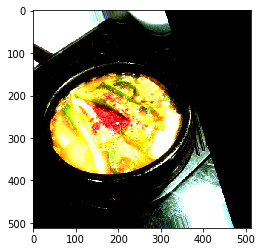

In [0]:
plt.imshow(np.reshape(d[1], (512, 512, 3)))

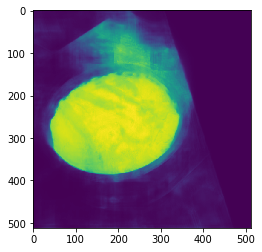

In [0]:
plt.imshow(np.reshape(predict_result[1], (512, 512)))

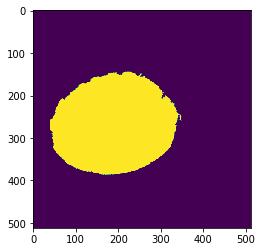

In [0]:
plt.imshow(np.reshape(l[1], (512, 512)))